### Курсовой проект 
Дьяченко Даниил @daniilstv

Построение модели, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по кредиту.
https://geekbrains.ru/lessons/58711


#### 1. Подгружаем модули, вспомогательные функции

In [3]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
#import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:

def df_info(input_dataframe):
    ''' Определение формы датафрейма. '''
    print("Форма: {}\n\nСтолбцы: {}\n\nИндексы: {}\n".format(input_dataframe.shape, 
                                          input_dataframe.columns, input_dataframe.index))
    print('Тип данных:\n',input_dataframe.dtypes)
    #print(input_dataframe.head())
    #print(input_dataframe.describe())
    
    return 


def clean_data_3std(df, columns):
    '''Стандартизация данных в 3 сигма'''
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
        conf_interval = mean + std3
        
        df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ] = mean
        

def make_dummy(df, column, dict_for_map):
    '''Dummy из словаря dict_for_map = {"Short Term": 0, "Long Term": 1} '''
    for i in column:
        print(i)
        maper = dict_for_map
        df[i] = df[i].map(maper)
    return 

def dict_from_value_counts(df, column):
    '''Словарь из агрегированных значений для преобразования в dummy'''  
    names = []
    for i in df[column].value_counts().index:
        names.append(i)
    dict_for_map = dict.fromkeys(names)
    return dict_for_map

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def print_scatter(df, col):
    '''Графики зависимости параметра и целевой переменной df[col]'''
    for i in col:
        print("Разброс параметра", i)
        plt.scatter(df[i],df["Credit Default"])
        plt.show()

def discrete_test(df, col):
    '''Проверка распределения дискретных значений  df[col]'''
    df[col].plot()
   # print(plt.show())
   # df[col].plot(kind="bar")
    print(plt.show())
    b = [col]
    for i in b:
        print(i)
        print(df_train[i].value_counts(), "\n") 


#### 2. Подгружаем данные, проводим поверхностный анализ фрейма

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'


df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [68]:
df_info(df_train)

Форма: (7499, 17)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

Индексы: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499],
           dtype='int64', length=7499)

Тип данных:
 Home Ownership                  category
Annual Income                    float64
Years in current job            category
Tax Liens                       category
Number of Open Accounts          float64
Years of Credit History          float64
Maximum Open Credit              float64
Number of Credit Problems       category
Months sinc

Категорийные признаки: Home Ownership, Years in current job, Tax Liens, Number of Credit Problems, Bankruptcies, Purpose, Term

In [6]:
# Привести к dummy  Home Ownership, Years in current job, Tax Liens, Number of Credit Problems, Bankruptcies, Purpose, Term

In [132]:
df_info(df_test)
df_test.head()

Форма: (2500, 16)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

Индексы: RangeIndex(start=0, stop=2500, step=1)

Тип данных:
 Home Ownership                    int64
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int64
Term                              int64
Current Loan Amount             float6

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,2,1.366922e+06,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,1,0,162470.0,105906.0,6813.0,0.0
1,2,2.318380e+05,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,12,0,78298.0,46037.0,2318.0,699.0
2,1,1.152540e+06,3.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,1,0,200178.0,146490.0,18729.0,7260.0
3,1,1.220313e+06,10.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,1,0,217382.0,213199.0,27559.0,739.0
4,1,2.340952e+06,6.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,1,1,777634.0,425391.0,42605.0,706.0


In [133]:
# Проверить на NaN
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [134]:
# Проверить на NaN
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

#### Заполнение пропусков

In [10]:
# Months since last delinquent: NaN -> 0
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


# Credit Score: NaN -> 0
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0
# df_test.loc[df_test['Years in current job'].isnull()]

df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

# Оценить корелляцию Years in current job с Annual Income

# df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test.loc[df_test['Annual Income'].isnull()
# df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train.loc[df_train['Annual Income'].isnull()

In [13]:
dict_from_value_counts(df_train, "Years in current job")

{'10+ years': None,
 '2 years': None,
 '3 years': None,
 '< 1 year': None,
 '5 years': None,
 '1 year': None,
 '4 years': None,
 '6 years': None,
 '7 years': None,
 '8 years': None,
 '9 years': None}

In [14]:
dict_for_map = {'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9}

make_dummy(df_train, ["Years in current job"], dict_for_map)
make_dummy(df_test, ["Years in current job"], dict_for_map)

Years in current job
Years in current job


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,0.0
1,Rent,231838.0,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10.0,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2.0,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,0.0
2497,Home Mortgage,1171806.0,2.0,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10.0,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [16]:
# Чекпоинт: Бэкап данных
df_train_ref = df_train.copy()
df_test_ref = df_test.copy()

df_train_ref.to_csv('df_train_ref.csv', index=False, encoding='utf-8')
df_test_ref.to_csv('df_test_ref.csv', index=False, encoding='utf-8')

In [6]:
# Старт с чекпоинта
df_train = pd.read_csv('df_train_ref.csv')
df_test = pd.read_csv('df_test_ref.csv')

In [7]:

# !Временное решение - в тупую убираем NaN
# ! как заполнить пропуски Years in current job по корелляции Years in current job с Annual Income
# ! заполнить пропуски Annual Income: по корелляции Years in current job

# Как можно заполнить регрессией?

col = 'Annual Income'
print(df_test.loc[ (df_test[col].notnull()),col ].mean())
df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

print(df_train.loc[ (df_train[col].notnull()),col ].mean())
df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



col = 'Years in current job'
a = np.round(df_test.loc[ (df_test[col].notnull()),col ].mean())
print(a)
df_test.loc[ (df_test[col].isnull()),col ] = a

a = np.round(df_train.loc[ (df_train[col].notnull()),col ].mean())
print(a)
df_train.loc[ (df_train[col].isnull()),col ] = a


1366921.6758933065
1366391.7201749957
6.0
6.0


#### Анализируем выбросы

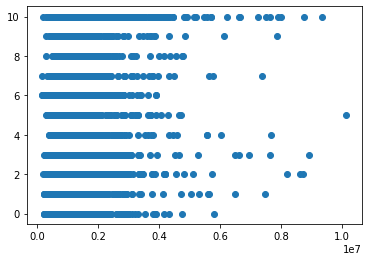

In [8]:
df = df_train[['Annual Income','Years in current job']]

plt.scatter(df_train['Annual Income'], df_train['Years in current job'])
plt.show()



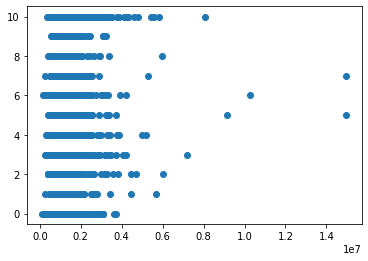

In [9]:
plt.scatter(df_test['Annual Income'], df_test['Years in current job'])
plt.show()

In [17]:
print(df_train.loc[df_train['Annual Income'] > 10000000,['Annual Income', 'Years in current job']])
print(df_test.loc[df_test['Annual Income'] > 8000000,['Annual Income', 'Years in current job']])

Empty DataFrame
Columns: [Annual Income, Years in current job]
Index: []
      Annual Income  Years in current job
36       14934114.0                   7.0
194      14975610.0                   5.0
860       8057178.0                  10.0
1089     10275770.0                   6.0
1235      9163985.0                   5.0


In [19]:
# Опция - удалить выбросы

#df_train = df_train.drop([6472])
#df_test = df_test.drop([36,194,1089])

In [82]:
value = np.round(df_train.loc[ ((df_train['Years in current job'] == 5) & (df_train['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_train.loc[6472,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 7) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[36,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 5) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[194,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 6) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[1089,['Annual Income']] = value



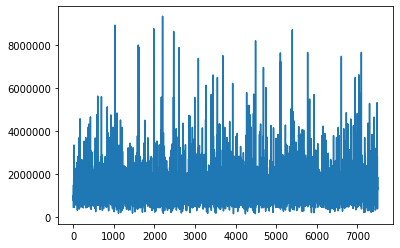

In [21]:
plt.plot(df_train['Annual Income'])

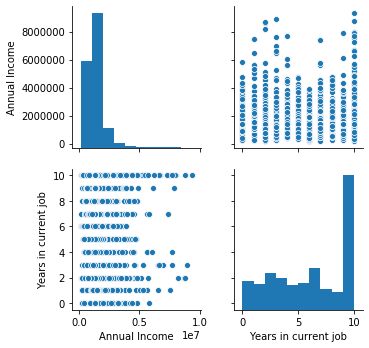

In [22]:
#Plot
#plt.figure(figsize=(10, 5), dpi= 240)
sns.pairplot(df_train[['Annual Income','Years in current job']])
plt.show()

In [23]:
df_info(df_train)

Форма: (7499, 17)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

Индексы: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499],
           dtype='int64', length=7499)

Тип данных:
 Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last d



#### 3. Вводим фиктивные переменные

In [ ]:
'''
df['IS_MALE'] = df['SEX'].map({'1':'1', '2':'0'}).astype(int)

for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    
'''

In [24]:
# Обзор object - признаков
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3203
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Purpose

debt consolidation      5943
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Term

Short Term    5555
Long Term     1944
Name: Term, dtype: int64
****************************************



In [25]:
dict_from_value_counts(df_train, 'Home Ownership')

{'Home Mortgage': None, 'Rent': None, 'Own Home': None, 'Have Mortgage': None}

In [26]:
dict_for_map = {'Home Mortgage': 1, 'Rent': 2, 'Own Home': 0, 'Have Mortgage': 3}

make_dummy(df_train, ['Home Ownership'], dict_for_map)
make_dummy(df_test, ['Home Ownership'], dict_for_map)

Home Ownership
Home Ownership


In [27]:
dict_from_value_counts(df_train, 'Purpose')

{'debt consolidation': None,
 'other': None,
 'home improvements': None,
 'business loan': None,
 'buy a car': None,
 'medical bills': None,
 'major purchase': None,
 'take a trip': None,
 'buy house': None,
 'small business': None,
 'wedding': None,
 'moving': None,
 'educational expenses': None,
 'vacation': None,
 'renewable energy': None}

In [28]:
dict_for_map = {'debt consolidation': 1,
 'other': 0,
 'home improvements': 2,
 'business loan': 3,
 'buy a car': 4,
 'medical bills': 5,
 'major purchase': 6,
 'take a trip': 7,
 'buy house': 8,
 'small business': 9,
 'wedding': 10,
 'moving': 11,
 'educational expenses': 12,
 'vacation': 13,
 'renewable energy': 14}

make_dummy(df_train, ['Purpose'], dict_for_map)
make_dummy(df_test, ['Purpose'], dict_for_map)

Purpose
Purpose


In [29]:
dict_from_value_counts(df_train, 'Term')

{'Short Term': None, 'Long Term': None}

In [30]:
dict_for_map = {'Short Term': 0, 'Long Term': 1}

make_dummy(df_train, ['Term'], dict_for_map)
make_dummy(df_test, ['Term'], dict_for_map)

Term
Term


In [31]:
# Выберем дискретные признаки
for i in df_train.columns:
    print(i)
    print(    df_train[i].value_counts(), "\n") 



Home Ownership
1    3637
2    3203
0     647
3      12
Name: Home Ownership, dtype: int64 

Annual Income
1.366392e+06    1557
1.043651e+06       4
1.058376e+06       4
1.338113e+06       4
1.161660e+06       4
                ... 
1.141254e+06       1
7.907382e+06       1
1.534478e+06       1
9.720400e+05       1
1.654786e+06       1
Name: Annual Income, Length: 5478, dtype: int64 

Years in current job
10.0    2332
6.0      797
2.0      705
3.0      620
0.0      563
5.0      515
1.0      504
4.0      469
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64 

Tax Liens
0.0    7365
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 

Number of Open Accounts
9.0     728
11.0    692
10.0    676
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0

In [32]:
# Проверка 
CAT_FEATURE_NAMES = [ 'Years in current job', 'Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies']
for i in CAT_FEATURE_NAMES:
    print(i)
    print(    df_train[i].value_counts(), "\n") 
    #print(    df_test[i].value_counts(), "\n") 

Years in current job
10.0    2332
6.0      797
2.0      705
3.0      620
0.0      563
5.0      515
1.0      504
4.0      469
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64 

Home Ownership
1    3637
2    3203
0     647
3      12
Name: Home Ownership, dtype: int64 

Purpose
1     5943
0      665
2      412
3      129
4       96
5       71
6       40
7       37
8       34
9       26
10      15
11      11
12      10
13       8
14       2
Name: Purpose, dtype: int64 

Term
0    5555
1    1944
Name: Term, dtype: int64 

Tax Liens
0.0    7365
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 

Number of Credit Problems
0.0    6468
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64 

Bankruptcies
0.0    6673
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64 



In [33]:
df_train['Years in current job'].astype('int')
df_test['Years in current job'].astype('int')

0        4
1        1
2        3
3       10
4        6
        ..
2495    10
2496     2
2497     2
2498    10
2499    10
Name: Years in current job, Length: 2497, dtype: int64

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

In [34]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_test.columns.drop(BASE_FEATURE_NAMES)

print("Переменные:", BASE_FEATURE_NAMES)
print("\nНовые переменные:", *NEW_FEATURE_NAMES)

df_train[TARGET_NAME].value_counts()
# Целевая переменная требует балансировки


Переменные: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

Новые переменные:


0    5386
1    2113
Name: Credit Default, dtype: int64

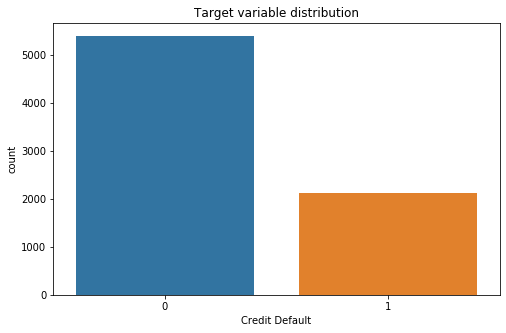

In [108]:
# Обзор распределения целевой переменной
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

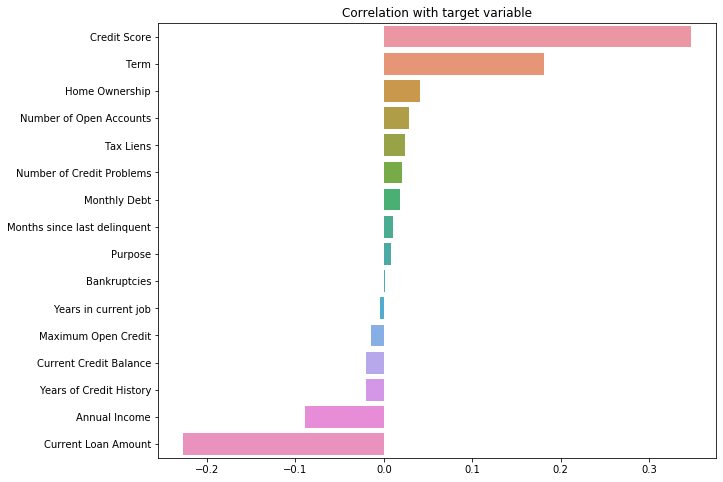

In [35]:
# Корреляция с базовыми признаками
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

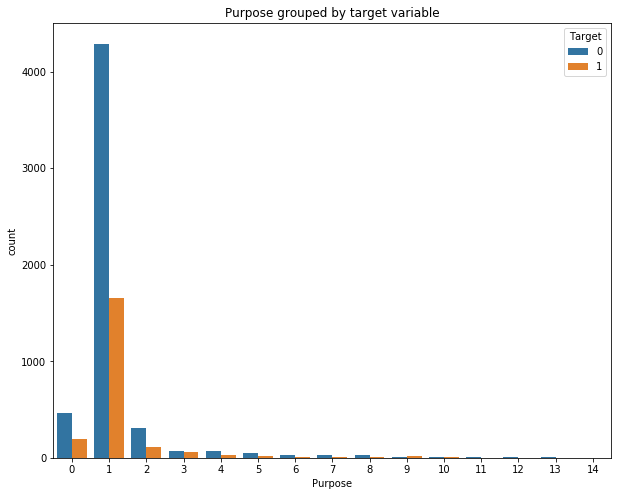

In [36]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [168]:
# Проверить гипотезу - Нулевая гипотеза: 1 и 2 согласованы
# 

In [37]:
# Как добавить ID - index?
Purpose_vs_target = df_train.loc[df_train['Purpose'].isin([0, 1]), ['ID'=index(df_train),'Purpose', 'Credit Default']]
Purpose_vs_target
# pay1_and_target_s = df.loc[df['PAY_1'].isin([-1, 0]), ['ID', 'PAY_1', 'NEXT_MONTH_DEFAULT']].sample(1000)

SyntaxError: invalid syntax (<ipython-input-37-8e6dc2e5ee16>, line 1)

In [39]:
Purpose_vs_target = df_train.loc[df_train['Purpose'].isin([0, 1]), ['Purpose', 'Credit Default']]
Purpose_vs_target


print(Purpose_vs_target['Purpose'].value_counts())
Purpose_vs_target['Credit Default'].value_counts()

# Purpose_vs_target_ = pd.DataFrame({'Purpose': [665, 5943], 'Credit Default': [4757, 1851]})
# Purpose_vs_target_

# table = Purpose_vs_target.pivot_table(values='ID', index='PAY_1', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
# table

1    5943
0     665
Name: Purpose, dtype: int64


0    4757
1    1851
Name: Credit Default, dtype: int64

In [42]:
# chi2, p, dof, expected = chi2_contingency(table, correction=False)
# p

0.0

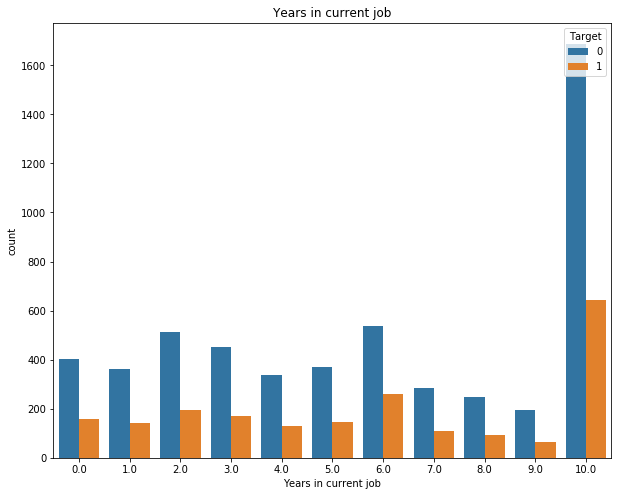

In [44]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job')
plt.legend(title='Target', loc='upper right')

plt.show()



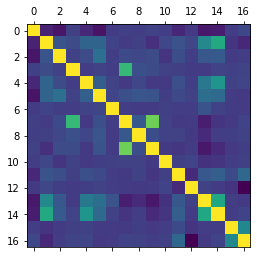

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Home Ownership,1,-0.104539,-0.150145,0.00793949,-0.0905176,-0.1627,-0.00623542,0.00647605,-0.000326057,0.0110857,-0.00485336,-0.0849271,-0.0166897,-0.14224,-0.130566,-0.00292256,0.0411856
Annual Income,-0.104539,1,0.0921105,0.0591792,0.169495,0.167788,0.0215369,-0.0132957,0.00528487,-0.0597963,0.0346533,0.0879534,0.0323672,0.35125,0.518371,-0.0360601,-0.0885323
Years in current job,-0.150145,0.0921105,1,0.0170653,0.0537046,0.219668,0.00326903,0.0478805,0.0358478,0.0560509,-0.0365607,0.0699114,-0.00134649,0.107066,0.12244,-0.00715278,-0.00394155
Tax Liens,0.00793949,0.0591792,0.0170653,1,-0.00536345,0.00910763,-0.00241036,0.595339,0.0706888,0.0574189,0.00835873,0.00494433,-0.00784043,-0.0101992,0.027288,0.00696278,0.0243597
Number of Open Accounts,-0.0905176,0.169495,0.0537046,-0.00536345,1,0.144816,0.0238953,-0.0178233,0.033991,-0.0188691,-0.0176955,0.0712997,0.00133488,0.267319,0.414374,0.0129263,0.0288654
Years of Credit History,-0.1627,0.167788,0.219668,0.00910763,0.144816,1,0.0292466,0.0712543,0.0973164,0.0855879,-0.000238628,0.0442346,0.0106176,0.217853,0.1922,-0.0137091,-0.0205773
Maximum Open Credit,-0.00623542,0.0215369,0.00326903,-0.00241036,0.0238953,0.0292466,1,-0.00475163,-0.0103567,-0.011634,0.00811476,-0.00602597,-0.00233646,0.088089,0.0102259,-0.00836858,-0.0142787
Number of Credit Problems,0.00647605,-0.0132957,0.0478805,0.595339,-0.0178233,0.0712543,-0.00475163,1,0.108906,0.730804,0.00872472,-0.0204607,-0.00861253,-0.12415,-0.042125,-0.0160986,0.0200605
Months since last delinquent,-0.000326057,0.00528487,0.0358478,0.0706888,0.033991,0.0973164,-0.0103567,0.108906,1,0.0676472,0.00955514,0.0093223,-0.0161502,-0.0824353,-0.00296553,0.00219027,0.0101328
Bankruptcies,0.0110857,-0.0597963,0.0560509,0.0574189,-0.0188691,0.0855879,-0.011634,0.730804,0.0676472,1,-0.0158181,-0.0310082,-0.00618441,-0.142567,-0.0787536,-0.0224497,0.00161237


In [45]:
X_corr = df_train.corr()
plt.matshow(X_corr)
plt.show()
X_corr.style.background_gradient(cmap='coolwarm')

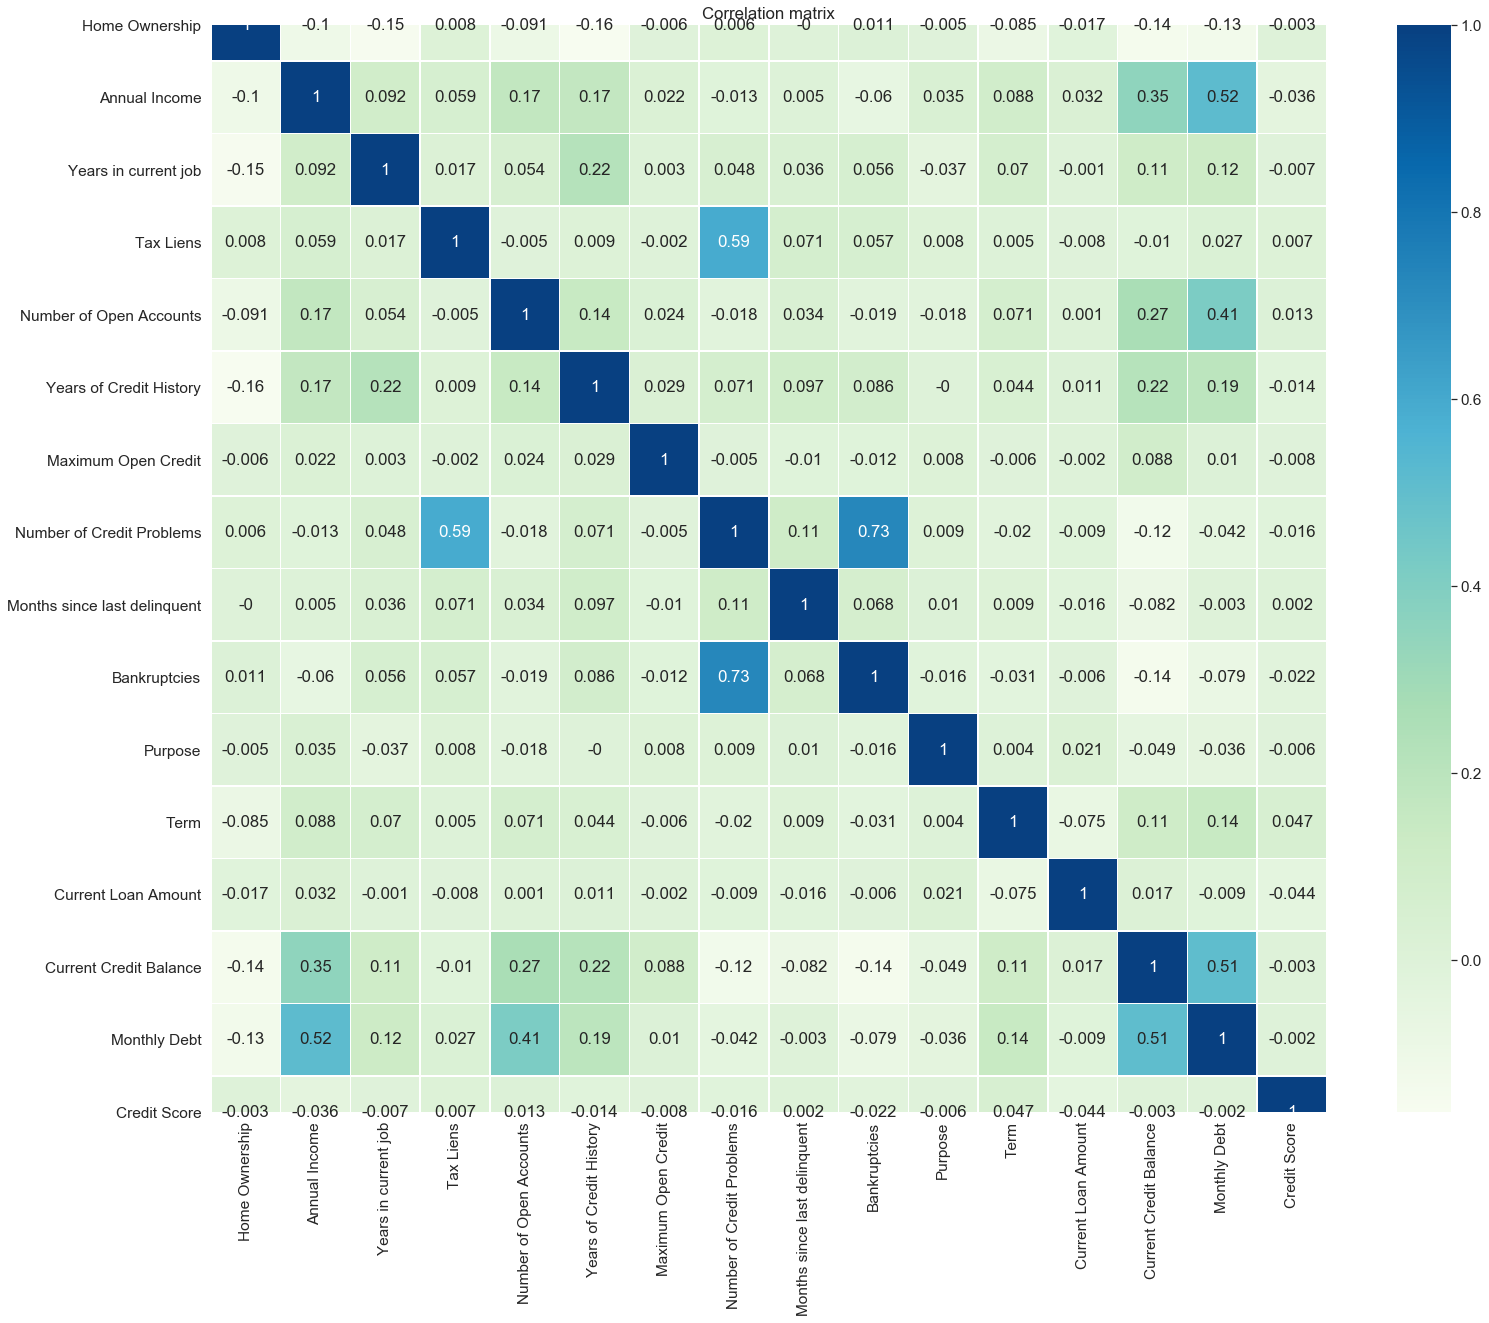

In [46]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [47]:
# Отбор признаков
print('BASE_FEATURE_NAMES:',BASE_FEATURE_NAMES)
print('\nCAT_FEATURE_NAMES:', CAT_FEATURE_NAMES)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))
print('\nNUM_FEATURE_NAMES:',NUM_FEATURE_NAMES)

SELECTED_FEATURE_NAMES = BASE_FEATURE_NAMES

BASE_FEATURE_NAMES: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES: ['Years in current job', 'Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies']

NUM_FEATURE_NAMES ['Number of Open Accounts', 'Months since last delinquent', 'Monthly Debt', 'Credit Score', 'Years of Credit History', 'Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']


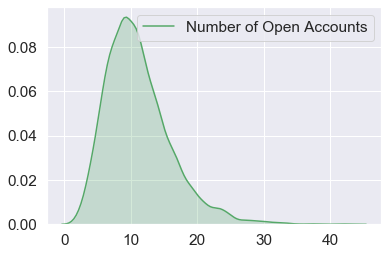

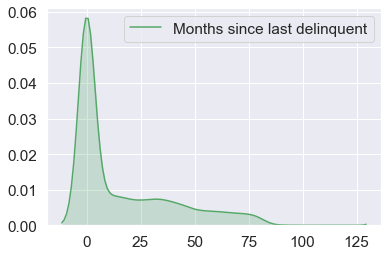

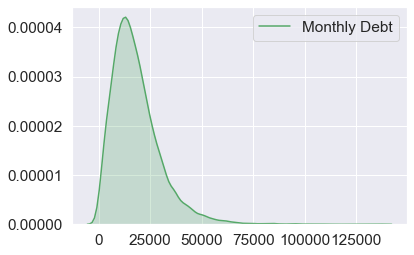

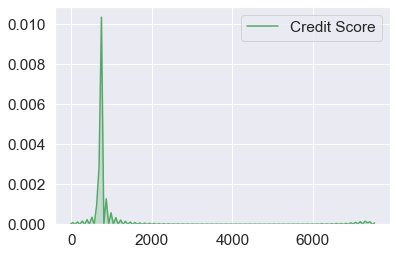

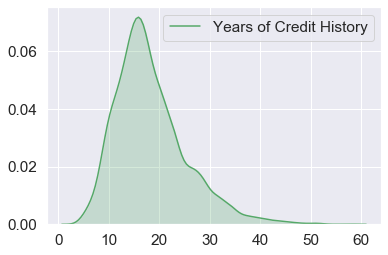

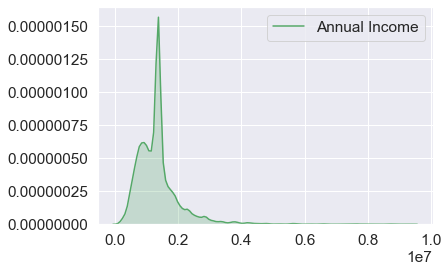

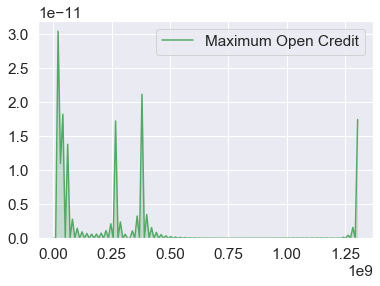

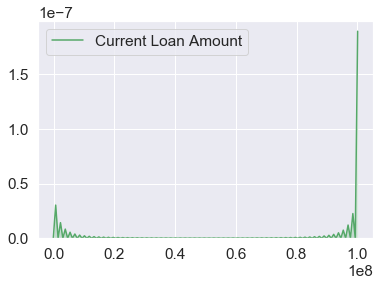

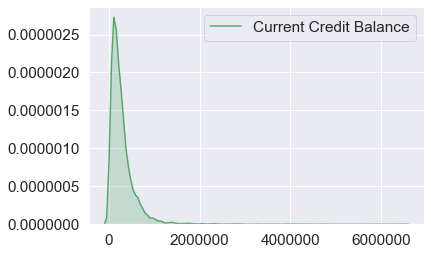

In [58]:
#plt.scatter(df_train['Annual Income'],df_train["Credit Score"])

col = NUM_FEATURE_NAMES

for i in col:
   # print(i)
    sns.kdeplot(df_train[i], shade=True, label=i, color='g')
    plt.show()




In [73]:
# обратное приведение типов для модели 
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.to_numeric(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Years in current job         float64
Home Ownership                 int64
Purpose                        int64
Term                           int64
Tax Liens                    float64
Number of Credit Problems    float64
Bankruptcies                 float64
dtype: object

In [74]:
# Нормализация данных

scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [75]:
# Разбиение на train и test
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [76]:
# Сохранение модели для нормализации данных
SCALER_FILE_PATH = '../scaler.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [77]:
# Балансировка целевой переменной
# Каким образом настраивается?
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3772
1    2954
Name: Credit Default, dtype: int64

In [78]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [145]:
# чекпоинт -  Сохранение обучающего и тестового датасетов

# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [79]:
# Логистическая регрессия
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3772
           1       0.62      0.50      0.55      2954

    accuracy                           0.65      6726
   macro avg       0.64      0.63      0.63      6726
weighted avg       0.64      0.65      0.64      6726

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1614
           1       0.43      0.46      0.45       636

    accuracy                           0.68      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1226  388
1                341  295


In [80]:
# knn ближайших соседей
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3772
           1       0.74      0.70      0.72      2954

    accuracy                           0.76      6726
   macro avg       0.76      0.75      0.75      6726
weighted avg       0.76      0.76      0.76      6726

TEST

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1614
           1       0.35      0.44      0.39       636

    accuracy                           0.61      2250
   macro avg       0.55      0.56      0.55      2250
weighted avg       0.64      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1096  518
1                354  282


#### Бустинговые алгоритмы

In [81]:
# XGBoost
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3772
           1       0.78      0.59      0.67      2954

    accuracy                           0.74      6726
   macro avg       0.75      0.73      0.73      6726
weighted avg       0.75      0.74      0.74      6726

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1614
           1       0.56      0.52      0.54       636

    accuracy                           0.75      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1353  261
1                308  328


In [82]:
# LightGBM
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

NameError: name 'lgbm' is not defined

In [ ]:
# Приведение типов для модели CatBoost
# for colname in CAT_FEATURE_NAMES:
#     df_train[colname] = pd.Categorical(df_train[colname])
    
# df_train[CAT_FEATURE_NAMES].dtypes

In [83]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3772
           1       0.94      0.87      0.90      2954

    accuracy                           0.92      6726
   macro avg       0.92      0.91      0.92      6726
weighted avg       0.92      0.92      0.92      6726

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1614
           1       0.57      0.49      0.53       636

    accuracy                           0.75      2250
   macro avg       0.69      0.67      0.68      2250
weighted avg       0.74      0.75      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  233
1                324  312


#### Выбор лучшей модели и подбор гиперпараметров

In [84]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [85]:
# Подбор гиперпараметров
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [86]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

In [ ]:
rs.best_params_

In [ ]:
rs.best_score_

#### Обучение и оценка финальной модели

In [ ]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [61]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                              int64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object